조회할 종목코드를 입력하세요 (예: 삼성전자 → 005930): 005380
재무정보 수집 중: 현대자동차 (005380)
CSV 저장 완료: /content/현대자동차_재무정보_2017이후.csv


,재무 항목,금액 (조 원)
0,자산총계,343.630
1,부채총계,222.065
2,자본총계,121.565
3,유동자산,115.735
4,비유동자산,227.896
5,유동부채,81.366
6,비유동부채,140.699
7,자본금,1.489
8,영업이익,3.634
9,당기순이익,3.382


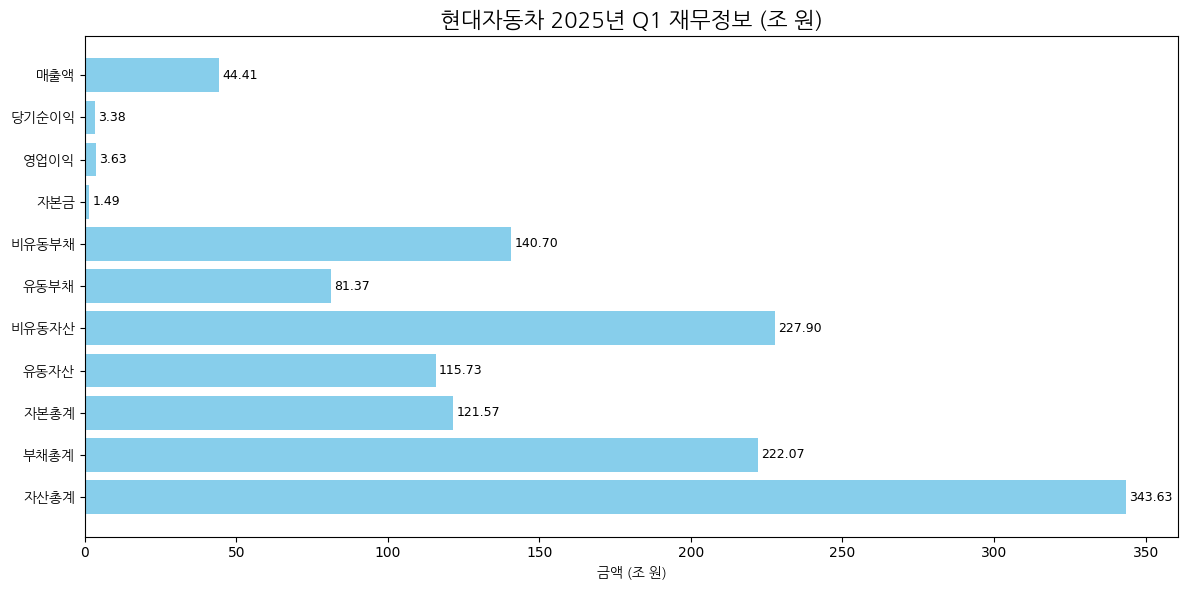

In [ ]:
# ✅ Colab 전용: DART 재무정보 수집 및 시각화 + Q4 매출 누계 보정
!apt-get -qq install -y fonts-nanum > /dev/null

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import requests
import zipfile
import xml.etree.ElementTree as ET
import time
import os
import warnings
import logging
from IPython.display import display, HTML

# ✅ 한글 폰트 설정 + 경고 제거
warnings.filterwarnings("ignore")
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
font_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf')

# 📌 1. DART 인증키
API_KEY = 'a4498e7f6b52a007d7af2b0b6db9dd2df66ed000'

# 📌 2. 안전한 GET 요청 함수 (최대 3회 재시도)
def safe_get(url, max_retries=3, sleep_time=1.0):
    for attempt in range(max_retries):
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response
        except Exception as e:
            print(f"[시도 {attempt + 1}] 요청 실패: {e}")
            time.sleep(sleep_time)
    print("요청 실패: 최대 재시도 횟수를 초과했습니다.")
    return None

# 📌 3. 종목코드 → (corp_code, corp_name) 매핑
def get_corp_code_dict():
    url = f"https://opendart.fss.or.kr/api/corpCode.xml?crtfc_key={API_KEY}"
    response = requests.get(url)
    with open("corp_code.zip", "wb") as f:
        f.write(response.content)
    with zipfile.ZipFile("corp_code.zip", "r") as zip_ref:
        zip_ref.extractall(".")
    tree = ET.parse("CORPCODE.xml")
    root = tree.getroot()
    corp_dict = {}
    for child in root.findall('list'):
        corp_name = child.find('corp_name').text.strip()
        stock_code = child.find('stock_code').text.strip()
        corp_code = child.find('corp_code').text.strip()
        if stock_code:
            corp_dict[stock_code] = (corp_code, corp_name)
    return corp_dict

# 📌 4. 재무정보 수집 및 저장
def get_financials_by_stock_code(stock_code, start_year=2017, end_year=2025):
    corp_code_dict = get_corp_code_dict()
    corp_info = corp_code_dict.get(stock_code)
    if not corp_info:
        print(f"[오류] 종목코드 '{stock_code}'에 해당하는 기업을 찾을 수 없습니다.")
        return None, None

    corp_code, corp_name = corp_info
    print(f"재무정보 수집 중: {corp_name} ({stock_code})")

    reprt_codes = {'Q1': '11013', 'Q2': '11012', 'Q3': '11014', 'Q4': '11011'}
    target_accounts = [
        '자산총계', '부채총계', '자본총계',
        '유동자산', '비유동자산',
        '유동부채', '비유동부채',
        '자본금', '매출액', '영업이익', '당기순이익'
    ]

    all_data = []
    current_year = pd.Timestamp.today().year
    current_month = pd.Timestamp.today().month

    for year in range(start_year, end_year + 1):
        for quarter, reprt_code in reprt_codes.items():
            if year == current_year and ((quarter == 'Q2' and current_month < 6) or
                                          (quarter == 'Q3' and current_month < 9) or
                                          (quarter == 'Q4' and current_month < 12)):
                continue

            url = f"https://opendart.fss.or.kr/api/fnlttSinglAcnt.json?crtfc_key={API_KEY}&corp_code={corp_code}&bsns_year={year}&reprt_code={reprt_code}"
            response = safe_get(url)
            if not response:
                continue

            res = response.json()
            if 'list' not in res or res.get('status') != '000':
                continue

            df = pd.DataFrame(res['list'])
            df = df[df['account_nm'].isin(target_accounts)]
            df = df[['account_nm', 'thstrm_amount']]
            df['year'] = year
            df['quarter'] = quarter
            all_data.append(df)

            time.sleep(1.0)

    if not all_data:
        print("유효한 재무데이터가 없습니다.")
        return None, None

    final_df = pd.concat(all_data)
    final_df = final_df.pivot_table(index=['year', 'quarter'], columns='account_nm', values='thstrm_amount', aggfunc='first').reset_index()

    sanitized_name = corp_name.replace("/", "_")
    save_path = f"{sanitized_name}_재무정보_{start_year}이후.csv"
    final_df.to_csv(save_path, index=False, encoding='utf-8-sig')
    print(f"CSV 저장 완료: {os.path.abspath(save_path)}")

    return final_df, corp_name

# 📌 5. 전처리 및 시각화
def preprocess_and_plot(df, corp_name):
    quarter_to_month = {'Q1': '03', 'Q2': '06', 'Q3': '09', 'Q4': '12'}
    df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['quarter'].map(quarter_to_month) + '-30')
    df = df.sort_values('date').reset_index(drop=True)

    for col in df.columns:
        if col not in ['year', 'quarter', 'date']:
            if df[col].dtype == 'object':
                df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce') / 1e12
            else:
                df[col] = df[col] / 1e12

    df_corrected = df.copy()
    for year in df['year'].unique():
        q4_row = df[(df['year'] == year) & (df['quarter'] == 'Q4')]
        q1 = df[(df['year'] == year) & (df['quarter'] == 'Q1')]['매출액']
        q2 = df[(df['year'] == year) & (df['quarter'] == 'Q2')]['매출액']
        q3 = df[(df['year'] == year) & (df['quarter'] == 'Q3')]['매출액']
        if not q4_row.empty and not (q1.empty or q2.empty or q3.empty):
            q4_idx = q4_row.index[0]
            q4_value = q4_row['매출액'].values[0]
            q123_sum = q1.values[0] + q2.values[0] + q3.values[0]
            df_corrected.loc[q4_idx, '매출액'] = q4_value - q123_sum
    df = df_corrected.copy()

    latest_quarter = df.iloc[[-1]]
    features = ['자산총계', '부채총계', '자본총계', '유동자산', '비유동자산',
                '유동부채', '비유동부채', '자본금', '영업이익', '당기순이익', '매출액']
    df_quarter = latest_quarter[features].T.reset_index()
    df_quarter.columns = ['재무 항목', '금액 (조 원)']
    df_quarter['금액 (조 원)'] = pd.to_numeric(df_quarter['금액 (조 원)'], errors='coerce')
    df_quarter = df_quarter.dropna(subset=['금액 (조 원)']).reset_index(drop=True)

    styled_table = df_quarter.style.set_table_attributes("style='display:inline' class='dataframe' border='1'") \
                                    .set_caption(f"{corp_name} {latest_quarter['year'].values[0]}년 {latest_quarter['quarter'].values[0]} 재무정보") \
                                    .format({"금액 (조 원)": "{:.3f}"})
    display(HTML(styled_table.to_html()))

    values = df_quarter['금액 (조 원)'].values
    labels = df_quarter['재무 항목'].values
    plt.figure(figsize=(12, 6))
    bars = plt.barh(np.arange(len(values)), values, color='skyblue')
    plt.yticks(np.arange(len(values)), labels, fontproperties=font_prop)
    plt.title(f"{corp_name} {latest_quarter['year'].values[0]}년 {latest_quarter['quarter'].values[0]} 재무정보 (조 원)", fontproperties=font_prop, fontsize=16)
    plt.xlabel("금액 (조 원)", fontproperties=font_prop)
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va='center', fontsize=9)
    plt.tight_layout()
    plt.show()

# 📌 6. 실행 흐름
stock_code = input("조회할 종목코드를 입력하세요 (예: 삼성전자 → 005930): ").strip()
df, corp_name = get_financials_by_stock_code(stock_code)
if df is not None:
    preprocess_and_plot(df, corp_name)


In [ ]:
# 📌 1. 매출액 Q4 누계 보정
df = df.sort_values(['year', 'quarter']).reset_index(drop=True)
df_corrected = df.copy()

for year in df['year'].unique():
    q4_mask = (df['year'] == year) & (df['quarter'] == 'Q4')
    q1 = df[(df['year'] == year) & (df['quarter'] == 'Q1')]['매출액']
    q2 = df[(df['year'] == year) & (df['quarter'] == 'Q2')]['매출액']
    q3 = df[(df['year'] == year) & (df['quarter'] == 'Q3')]['매출액']
    q4 = df[q4_mask]['매출액']

    if not q4.empty and not (q1.empty or q2.empty or q3.empty):
        try:
            q4_idx = df[q4_mask].index[0]
            q4_adjusted = pd.to_numeric(q4.values[0], errors='coerce') - (
                pd.to_numeric(q1.values[0], errors='coerce') +
                pd.to_numeric(q2.values[0], errors='coerce') +
                pd.to_numeric(q3.values[0], errors='coerce')
            )
            df_corrected.loc[q4_idx, '매출액'] = q4_adjusted
        except Exception as e:
            print(f"[오류] {year}년 Q4 보정 실패: {e}")

df = df_corrected.copy()

# 📌 2. 타겟 변수(y): 다음 분기 매출액
df['y'] = df['매출액'].shift(-1)

# 📌 3. 입력 변수(X)
features = ['자산총계', '부채총계', '자본총계', '유동자산', '비유동자산',
            '유동부채', '비유동부채', '자본금', '영업이익', '당기순이익', '매출액']

X = df[features].copy()
y = df['y'].copy()

# 📌 4. 문자열 → 숫자 + 조 단위 환산
for col in X.columns:
    X[col] = pd.to_numeric(X[col].astype(str).str.replace(',', ''), errors='coerce') / 1e12
y = pd.to_numeric(y.astype(str).str.replace(',', ''), errors='coerce') / 1e12

# 📌 5. NaN 제거 (타겟 기준)
X = X[y.notna()]
y = y[y.notna()]

📌 최적 하이퍼파라미터: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
✅ 검증 MAE: 2.4582 조 원
📈 다음 분기 매출 예측: 40.48 조 원


,Feature,Importance (%)
0,유동자산,17.20
1,자본총계,16.01
2,비유동자산,15.31
3,비유동부채,14.13
4,부채총계,12.78
5,자산총계,11.93
6,유동부채,7.89
7,영업이익,3.51
8,매출액,0.71
9,당기순이익,0.52


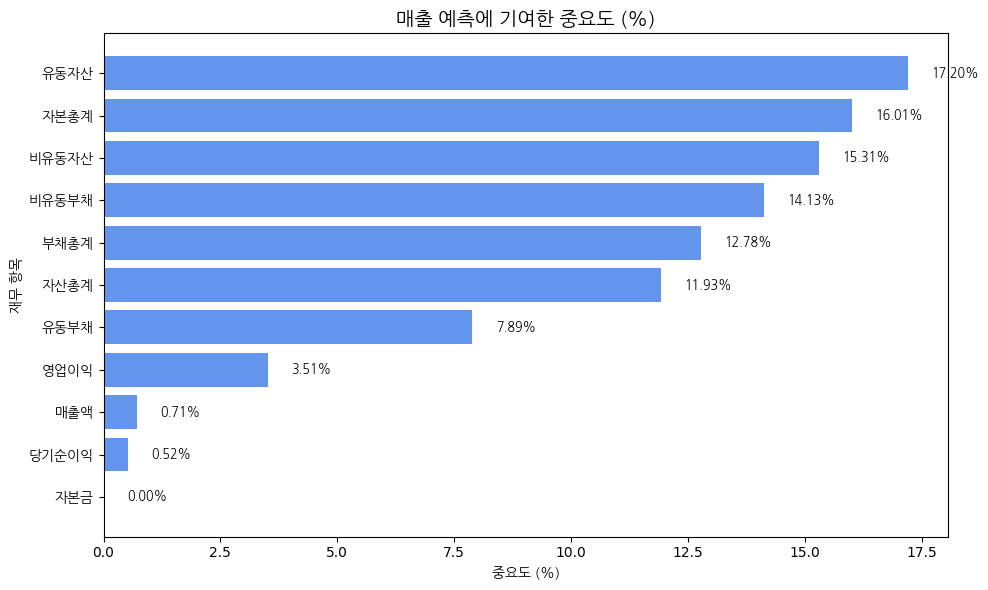

In [ ]:
# 📌 1. 라이브러리 불러오기 및 환경 설정
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from IPython.display import display

# ✅ 한글 폰트 설정 (Colab용)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family='NanumGothic')  # 전체 적용
plt.rcParams['axes.unicode_minus'] = False

# 📌 2. 데이터 분할 (시계열 데이터이므로 shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 📌 3. 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# 📌 4. GridSearchCV로 최적 모델 탐색
base_model = RandomForestRegressor(random_state=42)
grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)
grid.fit(X_train, y_train)

# 📌 5. 최적 모델 및 검증 출력
best_model = grid.best_estimator_
print("📌 최적 하이퍼파라미터:", grid.best_params_)

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"✅ 검증 MAE: {mae:.4f} 조 원")

# 📌 6. 다음 분기 매출 예측 (입력 정제 포함)
latest_X = df[features].iloc[[-1]].copy()

# 문자열 → 숫자 + 조 단위 변환
for col in latest_X.columns:
    latest_X[col] = pd.to_numeric(latest_X[col].astype(str).str.replace(',', ''), errors='coerce') / 1e12

# 예측
next_pred = best_model.predict(latest_X)[0]
print(f"📈 다음 분기 매출 예측: {next_pred:.2f} 조 원")

# 📌 7. 특성 중요도 분석
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
feature_importance_df['Importance (%)'] = (feature_importance_df['Importance'] * 100).round(2)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 📌 8. 표로 깔끔하게 출력
styled = feature_importance_df[['Feature', 'Importance (%)']].style\
    .set_caption("📌 매출 예측에 기여한 재무 항목별 중요도 (%)")\
    .format({"Importance (%)": "{:.2f}"})\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}])
display(styled)

# 📌 9. 그래프 시각화
plt.figure(figsize=(10, 6))
bars = plt.barh(
    np.arange(len(feature_importance_df)),
    feature_importance_df['Importance (%)'],
    color='cornflowerblue'
)

plt.gca().invert_yaxis()
plt.title("매출 예측에 기여한 중요도 (%)", fontproperties=font_prop, fontsize=14)
plt.xlabel("중요도 (%)", fontproperties=font_prop)
plt.ylabel("재무 항목", fontproperties=font_prop)

# ✅ 이 부분이 핵심!
plt.yticks(np.arange(len(feature_importance_df)), feature_importance_df['Feature'], fontproperties=font_prop)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
             f"{width:.2f}%", va='center', fontsize=9, fontproperties=font_prop)

plt.tight_layout()
plt.show()